In [21]:
%matplotlib inline
# For the capability
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

SyntaxError: from __future__ imports must occur at the beginning of the file (<ipython-input-21-3a2438c8fd17>, line 6)

In [ ]:
tf.set_random_seed(1)
np.random.seed(2)

batch_size = 50
learning_rate = 0.001              # learning rate
num_steps = 500
display_step = 100

In [ ]:
# Import MNIST data
mnist = input_data.read_data_sets('./data', one_hot=True)  # they has been normalized to range (0,1)

# plot one example
print('The shape of training data is: ', mnist.train.images.shape)     # (55000, 28 * 28)
print('The shape of training label is:', mnist.train.labels.shape)   # (55000, 10)
print('The shape of test data is: ', mnist.test.images.shape)     # (10000, 28 * 28)
print('The shape of test label is:', mnist.test.labels.shape)   # (10000, 10)
print('The shape of validation data is: ', mnist.validation.images.shape)     # (5000, 28 * 28)
print('The shape of validation label is:', mnist.validation.labels.shape)   # (5000, 10)

plt.imshow(mnist.train.images[10].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[10]))
plt.show()
print('The training label is:',mnist.train.labels[10])

In [22]:
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

![alt cnn](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/2934e9a15d0619d04ae4a4d4e2951e2ff4f45d93/21-FigureD.2-1.png)

In [23]:
tf_x = tf.placeholder(tf.float32, [None, 28*28]) / 255.
tf_y = tf.placeholder(tf.int32, [None, 10])

image = tf.reshape(tf_x, [-1, 28, 28, 1])   # (batch, height, width, channel)

# CNN
#https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/Conv2D
    
conv1 = tf.layers.conv2d(
    inputs=image,
    filters=32,
    kernel_size=[5, 5],
    padding='same',
    activation=tf.nn.relu)           # -> (28, 28, 32)

print("shape of conv1 is", conv1.shape)

#https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/MaxPooling2D

pool1 = tf.layers.max_pooling2d(
    inputs=conv1,
    pool_size=[2, 2],
    strides=2)           # -> (14, 14, 32)

print("shape of pool1 is", pool1.shape)

conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[5, 5], 
    padding='same', 
    activation=tf.nn.relu)    # -> (14, 14, 64)

print("shape of conv2 is", conv2.shape)

pool2 = tf.layers.max_pooling2d(
    inputs=conv2,
    pool_size=[2, 2],
    strides=2)    # -> (7, 7, 64)

print("shape of pool2 is", pool2.shape)

#https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/Flatten
flat = tf.layers.Flatten()(pool2)
print("shape of flat is", flat.shape)

#flat = tf.reshape(pool2, [-1, 7*7*64])          # -> (7*7*64, )
#print("shape of flat is", flat.shape)

#https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/Dense

dense2 = tf.layers.dense(
    inputs=flat,
    units=1024,
    activation=tf.nn.relu)
#https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/Dropout

#dropout = tf.layers.dropout(inputs=dense2, rate=0.4)

output = tf.layers.dense(
    inputs=dense2,
    units=10)             # output layer

shape of conv1 is (?, 28, 28, 32)
shape of pool1 is (?, 14, 14, 32)
shape of conv2 is (?, 14, 14, 64)
shape of pool2 is (?, 7, 7, 64)
shape of flat is (?, 3136)


In [24]:
# https://www.tensorflow.org/api_docs/python/tf/losses/softmax_cross_entropy
#loss_op = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=tf_y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/metrics/accuracy
accuracy = tf.metrics.accuracy(labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1))[1]
# return (acc, update_op), and create 2 local variables

In [25]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm

try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('\nPlease install sklearn for layer visualization\n')

def plot_with_labels(lowDWeights, labels):
    plt.cla(); X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

Step: 0 | train loss: 2.3024 | test accuracy: 0.09


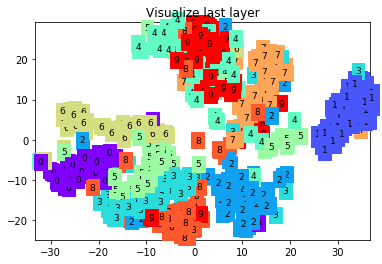

Step: 100 | train loss: 0.3188 | test accuracy: 0.52


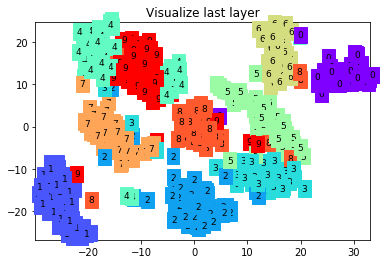

Step: 200 | train loss: 0.0150 | test accuracy: 0.67


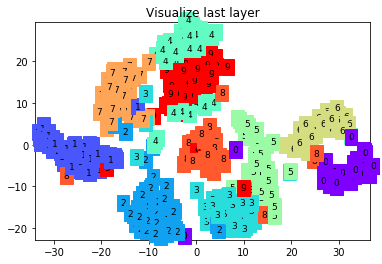

Step: 300 | train loss: 0.0554 | test accuracy: 0.74


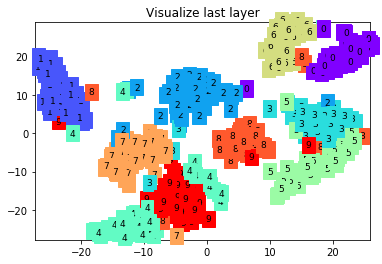

Step: 400 | train loss: 0.1379 | test accuracy: 0.79


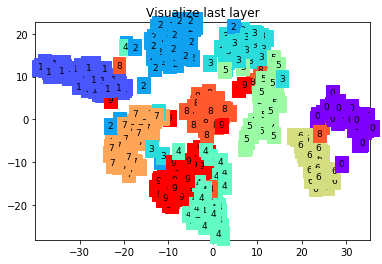

Model saved in file: cnn_model_old


In [26]:
#sess = tf.Session()
# https://www.tensorflow.org/api_docs/python/tf/group
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# Start training
with tf.Session() as sess:
    sess.run(init_op)     # initialize var in graph

    plt.ion()
    
    for step in range(num_steps):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        _, loss_ = sess.run([train_op, loss_op], {tf_x: batch_x, tf_y: batch_y})
        if step % display_step == 0:
            accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_x, tf_y: test_y})
            print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000); plot_only = 500
                low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
                labels = np.argmax(test_y, axis=1)[:plot_only]; plot_with_labels(low_dim_embs, labels)
    plt.ioff()

    # Save model weights to disk
    save_path = saver.save(sess, "cnn_model_old")
    print("Model saved in file: %s" % save_path)

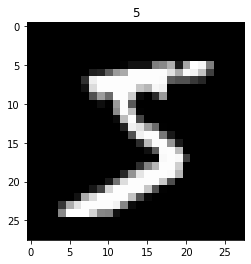

The test label is: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
INFO:tensorflow:Restoring parameters from cnn_model_old
Model restored from file: cnn_model_old
Answer: [5]
prediction: [[7.4155274e-08 5.3886822e-07 3.2821725e-07 9.9800557e-02 3.1809630e-09
  9.0007269e-01 1.6315267e-06 8.7722822e-07 1.1646893e-04 7.0051242e-06]]
INFO:tensorflow:Restoring parameters from cnn_model_old
Model restored from file: cnn_model_old
[5 0 4 1 9 2 1 3 1 4] prediction number
[5 0 4 1 9 2 1 3 1 4] real number


In [27]:
# Evaluate model
prediction = tf.nn.softmax(output)
#correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(tf_y, 1))
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# argmax returns the index with the largest value across axes of a tensor
ans = tf.argmax(prediction, 1)

# Show image that we want to predict
plt.imshow(mnist.validation.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.validation.labels[0]))
plt.show()
print('The test label is:',mnist.validation.labels[0])

# Running a validation dataset by loading the model saved earlier
with tf.Session() as sess:
    # Run the initializer
    sess.run(init_op)

    saver.restore(sess, "cnn_model_old")
    print("Model restored from file: %s" % save_path)
    
    # Calculate the answer for the image
    print("Answer:", sess.run(ans, feed_dict={tf_x: mnist.validation.images[0:1]}))
    print("prediction:", sess.run(prediction, feed_dict={tf_x: mnist.validation.images[0:1]}))

# print 10 predictions from test data
with tf.Session() as sess:
    # Run the initializer
    sess.run(init_op)
    
    saver.restore(sess, "cnn_model_old")
    print("Model restored from file: %s" % save_path)
    
    test_output = sess.run(output, {tf_x: mnist.validation.images[:10]})
    pred_y = np.argmax(test_output, 1)
    print(pred_y, 'prediction number')
    print(np.argmax(mnist.validation.labels[:10], 1), 'real number')